In [164]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf

In [165]:
# Define the true objective function z = f(x, y)
def obj_func(x):
    return -(20 * (np.exp(-0.2 * np.sqrt(0.5 * (x**2)))) - np.exp(0.5 * (np.cos(2 * np.pi * x))) + np.e + 20)

In [166]:
# Random Noise that will be added to data Response
ran_err = lambda n, x: np.random.normal(0, x, n)
sys_err = lambda n, x, a: (0.1 * a**2 - 0.5 * a + 2) + np.random.normal(0, x, n)

In [167]:
# Random Seed
np.random.seed(1)

# number of physical observations 
phy_n = 10 

# number of simulated observations
sim_n = 50

# Random Seed
r = np.random.default_rng(seed=2)

In [168]:
# Generate synthetic data for training the neural network
x_range = [(-5, 5)]

# Generate the meshgrid and response for the plots
X = np.arange(*x_range[0], ((x_range[0][1] - x_range[0][0]) / 1000))
Z = obj_func(X)

# Generate the initial physical experiments
df = pd.DataFrame(r.uniform(x_range[0][0], x_range[0][1], size=(phy_n, 1)))
df.columns = ["x"]
df["z"] = obj_func(df['x']) + ran_err(phy_n, 0.05)

#Generate Simulated Data
sim_df = pd.DataFrame(r.uniform(x_range[0][0], x_range[0][1], size=(sim_n, 1)))
sim_df.columns = ["x"]
sim_df["z"] = obj_func(sim_df['x']) + sys_err(sim_n, 0.02, sim_df['x'])


data = pd.DataFrame({'x': X, 'z': Z})
data['z'] = obj_func(data['x']) + sys_err(1000, 0.02, data['x'])

print(data)


# Preprocess the data 
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Define the hyperparameter space
hyp_space  = [
    Integer(2, 5, name='num_layers'), # Num of layers in the network (depth)
    Integer(10, 100, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.0001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(10, 50, name='batch_size'), # Num of samples per batch
    Integer(10, 50, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

        x          z
0   -5.00 -23.946022
1   -4.99 -23.936449
2   -4.98 -23.985055
3   -4.97 -24.038271
4   -4.96 -24.062643
..    ...        ...
995  4.95 -29.032827
996  4.96 -29.026830
997  4.97 -28.969498
998  4.98 -28.967096
999  4.99 -28.947679

[1000 rows x 2 columns]


In [169]:
# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(1,))
    x = Dense(num_units, activation='relu')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    kfold = KFold(n_splits=3)
    scores = []

    for train_idx, val_idx in kfold.split(X):
        model.fit(X[train_idx], Z[train_idx], epochs=epochs, batch_size=batch_size, verbose=0)
        score = model.evaluate(X[val_idx], Z[val_idx], verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=50, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

Best hyperparameters:
num_layers: 2
num_units: 97
learning_rate: 0.009107938876437578
dropout_rate: 0.08545479256802259
batch_size: 24
epochs: 40


In [170]:
# Train model on Simulated Data
best_model.fit(sim_df["x"], sim_df["z"], epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Reduce learning rate for fine-tuning
fine_tune_learning_rate = result.x[2] / 10
best_model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate), loss='mean_squared_error')

# Fine-tune the model on physical data
best_model.fit(df["x"], df["z"], epochs=result.x[5] // 2, batch_size=result.x[4], verbose=1)

# Since we have very limited physical data, use all physical data for evaluation
evaluation = best_model.evaluate(df["x"], df["z"])
print("Evaluation on physical data:", evaluation)

Epoch 1/40


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1143.1353  
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 964.0745  
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 714.2982 
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 489.8647 
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 332.9696 
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 455.4600 
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 468.0480 
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 328.9879 
Epoch 9/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 245.5055 
Epoch 10/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 281.5818 
Epoch 11/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 256.4572 
Epoch 12/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 210.9176 
Epoch 13/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157.9859 
Epoch 14/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106.7527 
Epoch 15/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94.2136  
Epoch 16/40


In [171]:
# Train the model
# best_model.fit(X, Z, epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=100):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

# Make predictions with MC Dropout
mean, std = mc_dropout_predictions(best_model, X)

# Selecting new points with highest uncertainty
num_new_points = 10  # Num of new points to sample
new_points_indices = np.argsort(std)[-num_new_points:]
new_points = X[new_points_indices]

print("New points to sample:")
print(new_points)

New points to sample:
[-0.01  0.12 -0.44  0.05 -0.47 -0.14  0.17 -0.06 -0.7   0.46]


In [172]:
test_x = data["x"]
test_x

0     -5.00
1     -4.99
2     -4.98
3     -4.97
4     -4.96
       ... 
995    4.95
996    4.96
997    4.97
998    4.98
999    4.99
Name: x, Length: 1000, dtype: float64

In [173]:
response_x = best_model.predict(test_x)
response_x

temp_df = pd.DataFrame(data=test_x, columns=["x"])
temp_df["z"] = response_x.flatten()

print(temp_df)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
        x          z
0   -5.00 -29.764688
1   -4.99 -29.785166
2   -4.98 -29.805641
3   -4.97 -29.826117
4   -4.96 -29.846596
..    ...        ...
995  4.95 -30.916090
996  4.96 -30.904036
997  4.97 -30.891985
998  4.98 -30.879932
999  4.99 -30.868532

[1000 rows x 2 columns]


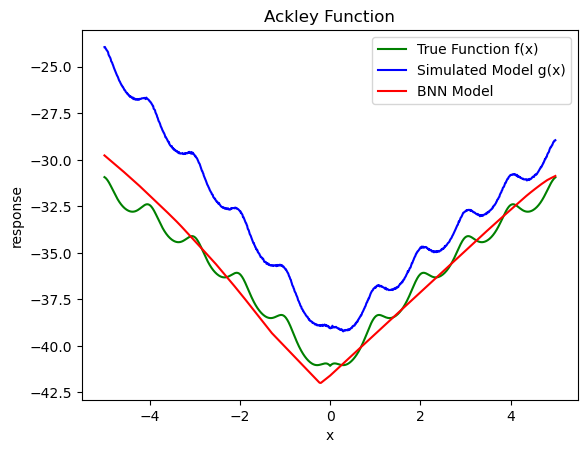

In [174]:
import matplotlib.pyplot as plt

sim_df = sim_df.sort_values(by='x')
temp_df = temp_df.sort_values(by='x')

plt.plot(X, Z, label='True Function f(x)', color="green")
plt.plot(data['x'], data['z'], label='Simulated Model g(x)', color="blue")
plt.plot(temp_df['x'], temp_df['z'], label='BNN Model', color="red")
plt.legend()
plt.xlabel('x')
plt.ylabel('response')
plt.title('Ackley Function')
plt.show()

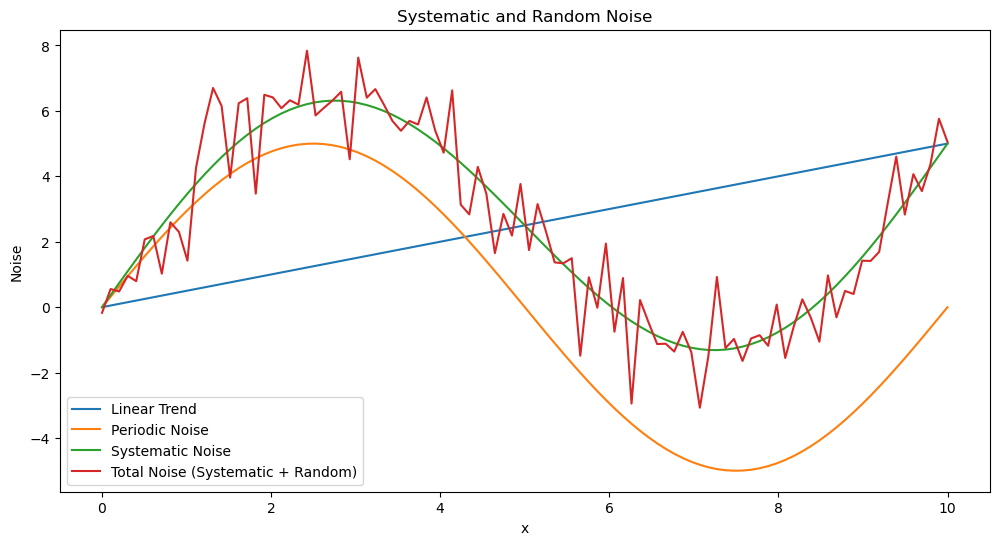

In [175]:
import numpy as np
import matplotlib.pyplot as plt

n = 100
x = np.linspace(0, 10, n)
linear_trend = 0.5 * x
frequency = 0.1
amplitude = 5
periodic_noise = amplitude * np.sin(2 * np.pi * frequency * x)
random_noise = np.random.normal(0, 1, n)
systematic_noise = linear_trend + periodic_noise

# Combined noise
total_noise = systematic_noise + random_noise

# Plotting the noise
plt.figure(figsize=(12, 6))
plt.plot(x, linear_trend, label='Linear Trend')
plt.plot(x, periodic_noise, label='Periodic Noise')
plt.plot(x, systematic_noise, label='Systematic Noise')
plt.plot(x, total_noise, label='Total Noise (Systematic + Random)')
plt.legend()
plt.xlabel('x')
plt.ylabel('Noise')
plt.title('Systematic and Random Noise')
plt.show()